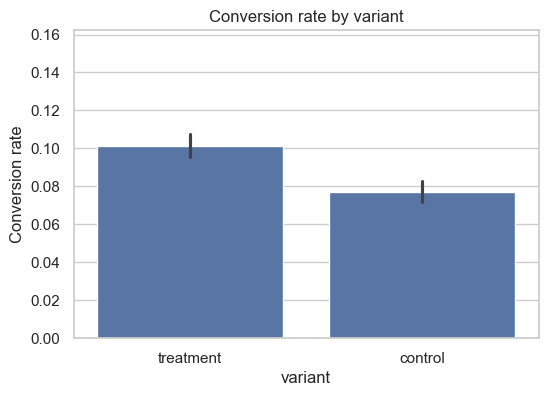

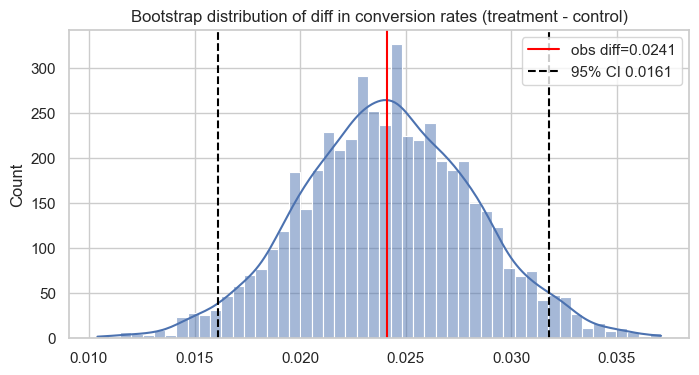

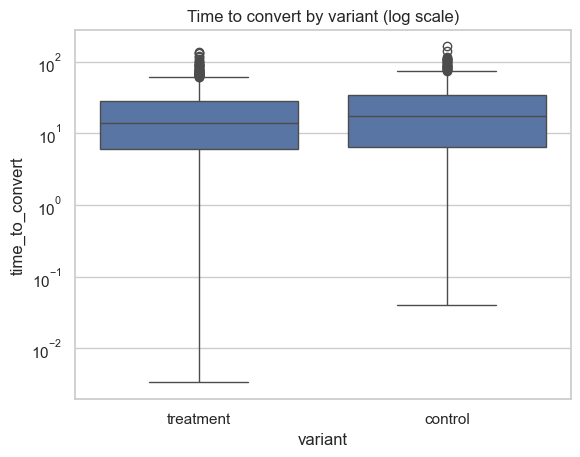

,users,conversions,conversion_rate,retention,mean_sessions,uplift_vs_control
variant,,,,,,
control,10000,773,0.0773,0.1544,1.1619,0.0000
treatment,10000,1014,0.1014,0.1926,1.2985,0.0241


In [2]:
# A/B Test Experimentation Project
# 1) Simulate dataset
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

np.random.seed(42)

def simulate_ab(n_users=20000, pct_treatment=0.5,
                p_control=0.08, uplift=0.015,
                avg_time_control=24, avg_time_treatment=20):
    """
    Simulate per-user A/B test data.
    - n_users: total users
    - pct_treatment: fraction assigned to treatment
    - p_control: base conversion rate in control
    - uplift: absolute uplift in conversion for treatment
    - avg_time_control/treatment: mean hours to convert (Exp dist)
    """
    n_treat = int(n_users * pct_treatment)
    n_control = n_users - n_treat
    rows = []
    start = datetime(2025,1,1)
    for i in range(n_users):
        uid = i+1
        variant = 'treatment' if i < n_treat else 'control'
        signup_date = start + timedelta(seconds=np.random.randint(0, 86400*30))
        if variant == 'control':
            converted = np.random.rand() < p_control
            if converted:
                time_to_convert = np.random.exponential(avg_time_control)
            else:
                time_to_convert = np.nan
            sessions_7d = np.random.poisson(1 if not converted else 3)
            retained_7d = int(sessions_7d>0 and (np.random.rand() < (0.2 if not converted else 0.5)))
        else:
            p_treat = p_control + uplift
            converted = np.random.rand() < p_treat
            if converted:
                time_to_convert = np.random.exponential(avg_time_treatment)
            else:
                time_to_convert = np.nan
            sessions_7d = np.random.poisson(1 if not converted else 4)
            retained_7d = int(sessions_7d>0 and (np.random.rand() < (0.25 if not converted else 0.55)))
        rows.append((uid, variant, signup_date, int(converted), time_to_convert, sessions_7d, retained_7d))
    df = pd.DataFrame(rows, columns=['user_id','variant','signup_date','converted','time_to_convert','sessions_7d','retained_7d'])
    return df

df = simulate_ab(n_users=20000, pct_treatment=0.5, p_control=0.08, uplift=0.02)
df.to_csv('ab_simulated_data.csv', index=False)
df.head()

# 2) Descriptive statistics
df.groupby('variant').agg(
    users=('user_id','count'),
    conversions=('converted','sum'),
    conversion_rate=('converted','mean'),
    mean_sessions=('sessions_7d','mean'),
    retention_rate=('retained_7d','mean')
).reset_index()

# 3) Visualize conversion rates and counts
sns.set(style='whitegrid')
rates = df.groupby('variant')['converted'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x='variant', y='converted', data=df, estimator=np.mean)
plt.ylabel('Conversion rate')
plt.title('Conversion rate by variant')
plt.ylim(0, rates['converted'].max()*1.6)
plt.show()

# 4) Bootstrap difference-in-proportions
def bootstrap_diff_prop(data, B=10000):
    treat = data.loc[data['variant']=='treatment','converted'].values
    control = data.loc[data['variant']=='control','converted'].values
    n_t = len(treat); n_c = len(control)
    obs_diff = treat.mean() - control.mean()
    diffs = np.empty(B)
    for i in range(B):
        s_t = np.random.choice(treat, size=n_t, replace=True)
        s_c = np.random.choice(control, size=n_c, replace=True)
        diffs[i] = s_t.mean() - s_c.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    p_val = np.mean(diffs <= 0)  # one-sided p for uplift > 0
    return obs_diff, (ci_low, ci_high), p_val

obs_diff, ci, p_val = bootstrap_diff_prop(df, B=5000)
obs_diff, ci, p_val

# 5) Visualize bootstrap distribution
B=5000
treat = df.loc[df['variant']=='treatment','converted'].values
control = df.loc[df['variant']=='control','converted'].values
n_t = len(treat); n_c = len(control)
diffs = []
for i in range(B):
    diffs.append(np.random.choice(treat, size=n_t, replace=True).mean() - np.random.choice(control, size=n_c, replace=True).mean())
diffs = np.array(diffs)
plt.figure(figsize=(8,4))
sns.histplot(diffs, bins=50, kde=True)
plt.axvline(obs_diff, color='red', label=f'obs diff={obs_diff:.4f}')
plt.axvline(ci[0], color='black', linestyle='--', label=f'95% CI {ci[0]:.4f}')
plt.axvline(ci[1], color='black', linestyle='--')
plt.legend()
plt.title('Bootstrap distribution of diff in conversion rates (treatment - control)')
plt.show()

# 6) Secondary tests: time to convert (only among converters)
time_conv = df.dropna(subset=['time_to_convert'])
sns.boxplot(x='variant', y='time_to_convert', data=time_conv)
plt.yscale('log')
plt.title('Time to convert by variant (log scale)')
plt.show()

# t-test on log-transformed times
control_times = np.log(time_conv[time_conv['variant']=='control']['time_to_convert'])
treat_times = np.log(time_conv[time_conv['variant']=='treatment']['time_to_convert'])
stats.ttest_ind(treat_times, control_times, equal_var=False)

# 7) Report key metrics in a small table
summary = df.groupby('variant').agg(
    users=('user_id','count'),
    conversions=('converted','sum'),
    conversion_rate=('converted','mean'),
    retention=('retained_7d','mean'),
    mean_sessions=('sessions_7d','mean')
).round(4)
summary['uplift_vs_control'] = summary['conversion_rate'] - summary.loc['control','conversion_rate']
summary
